滑動方框框小矮人藍線範圍 + 貞差法 + HSV

In [3]:
import os
import cv2
import numpy as np

def detect_blue_stripes(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define blue color range in HSV
    lower_blue = np.array([90, 95, 50])
    upper_blue = np.array([150, 255, 255])
    
    # Create a mask for the blue color range
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Apply the mask to extract blue regions
    blue_regions = cv2.bitwise_and(image, image, mask=mask)
    
    return blue_regions

def get_blue_line_coordinates(binary_image):
    coordinates = np.column_stack(np.where(binary_image > 0))
    return coordinates

def save_coordinates(coordinates, file_path):
    with open(file_path, 'w') as file:
        for coord in coordinates:
            # Reverse the order to x, y
            file.write(f"{coord[0]}, {coord[1]}\n")
            
def apply_rectangle_mask(image, start_x, start_y, width, height, move_step, index):
    """Apply a mask to keep only the area within the moving rectangle."""
    mask = np.zeros_like(image, dtype=np.uint8)
    move_x = start_x + (index // move_step) * 10  # Calculate the moving x-coordinate of the rectangle
    cv2.rectangle(mask, (move_x, start_y), (move_x + width, start_y + height), (255), thickness=-1)
    return cv2.bitwise_and(image, image, mask=mask)

def process_images(input_folder, output_folder_base, threshold):
    if not os.path.exists(input_folder):
        print(f"Error: Input folder '{input_folder}' does not exist.")
        return

    # Create folders for original and binary results
    output_folder_original_L = output_folder_base + "original_L"
    output_folder_original_R = output_folder_base + "original_R"
    output_folder_binary_L = output_folder_base + "binary_blue_line_result_L"
    output_folder_binary_R = output_folder_base + "binary_blue_line_result_R"
    output_folder_coords_L = output_folder_base + "coords_L"
    output_folder_coords_R = output_folder_base + "coords_R"
    
    # Ensure all folders exist
    for folder in [output_folder_original_L, output_folder_original_R, output_folder_binary_L, output_folder_binary_R, output_folder_coords_L, output_folder_coords_R]:
        os.makedirs(folder, exist_ok=True)
    
    images = [img for img in os.listdir(input_folder) if img.endswith(".jpg")]
    images.sort()  # Ensure images are processed in order
    
    for i, img_name in enumerate(images):
        image_path = os.path.join(input_folder, img_name)
        image = cv2.imread(image_path)

        # Extract blue lines
        blue_regions = detect_blue_stripes(image)
        
        # Convert to grayscale
        gray = cv2.cvtColor(blue_regions, cv2.COLOR_BGR2GRAY)
        
        # Threshold to get binary image
        _, binary_image = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        
        # Split image into left and right
        width = image.shape[1]
        left_part = image[:, :width // 2]
        right_part = image[:, width // 2:]
        binary_left = binary_image[:, :width // 2]
        binary_right = binary_image[:, width // 2:]
        
        # Save original left and right images
        cv2.imwrite(os.path.join(output_folder_original_L, f"original_{i:04d}.jpg"), left_part)
        cv2.imwrite(os.path.join(output_folder_original_R, f"original_{i:04d}.jpg"), right_part)

        # Save masked_binary left and right images
        masked_left = apply_rectangle_mask(binary_left, 100, 50, 225, 825, 6, i)
        masked_right = apply_rectangle_mask(binary_right, 200, 0, 150, 890, 7, i)
        cv2.imwrite(os.path.join(output_folder_binary_L, f"binary_{i:04d}.jpg"), masked_left)
        cv2.imwrite(os.path.join(output_folder_binary_R, f"binary_{i:04d}.jpg"), masked_right)

        # Get coordinates of blue lines
        coords_left = get_blue_line_coordinates(masked_left)
        coords_right = get_blue_line_coordinates(masked_right)

        # Save coordinates to text files
        save_coordinates(coords_left, os.path.join(output_folder_coords_L, f"coords_original_{i:04d}.txt"))
        save_coordinates(coords_right, os.path.join(output_folder_coords_R, f"coords_original_{i:04d}.txt"))

input_folder = "./SBS images"  # Actual folder path for images
output_folder_base = "output_images/"  # Base folder path for results
# Check if the folder exists
if not os.path.exists(output_folder_base):
    # If it does not exist, create the folder
    os.makedirs(output_folder_base)
    print(f"Folder {output_folder_base} has been created.")
else:
    print(f"Folder {output_folder_base} already exists.")



threshold = 8  # Threshold for binary image creation

process_images(input_folder, output_folder_base, threshold)


Folder output_images/ already exists.


單張epipolor+ RANSAC

Matches:  [(array([333., 282.], dtype=float32), array([381., 239.], dtype=float32)), (array([334., 282.], dtype=float32), array([381., 239.], dtype=float32)), (array([333., 283.], dtype=float32), array([381., 240.], dtype=float32)), (array([332., 284.], dtype=float32), array([381., 241.], dtype=float32)), (array([333., 284.], dtype=float32), array([381., 241.], dtype=float32)), (array([332., 285.], dtype=float32), array([381., 242.], dtype=float32)), (array([333., 285.], dtype=float32), array([381., 242.], dtype=float32)), (array([332., 286.], dtype=float32), array([381., 243.], dtype=float32)), (array([333., 286.], dtype=float32), array([381., 243.], dtype=float32)), (array([332., 287.], dtype=float32), array([381., 244.], dtype=float32)), (array([331., 288.], dtype=float32), array([380., 247.], dtype=float32)), (array([331., 289.], dtype=float32), array([380., 247.], dtype=float32)), (array([330., 290.], dtype=float32), array([380., 248.], dtype=float32)), (array([331., 290.], dtype=

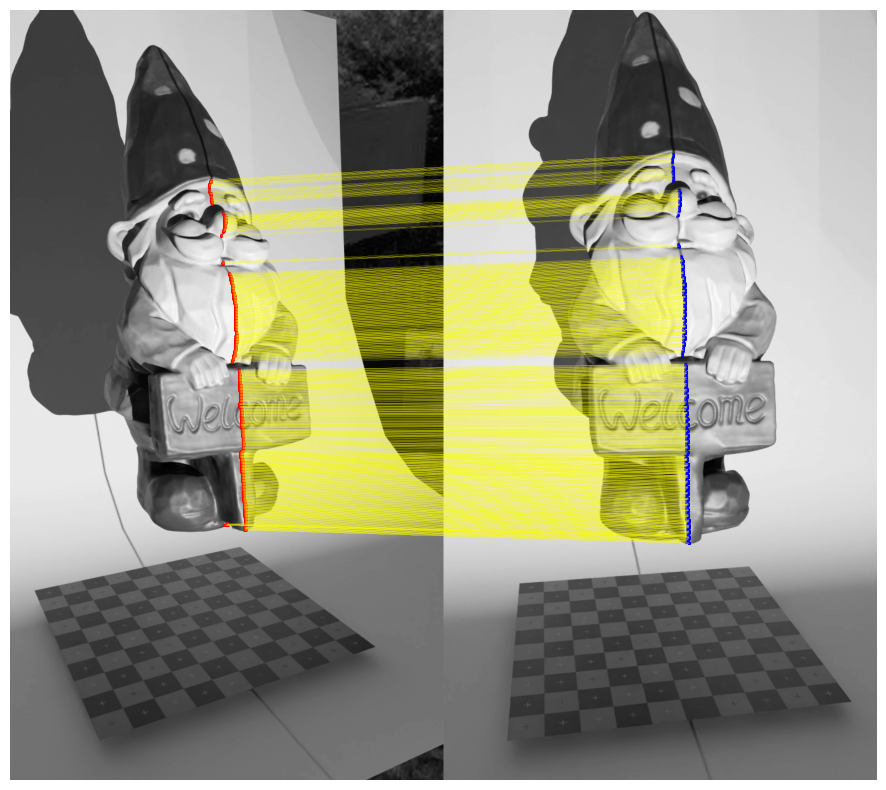

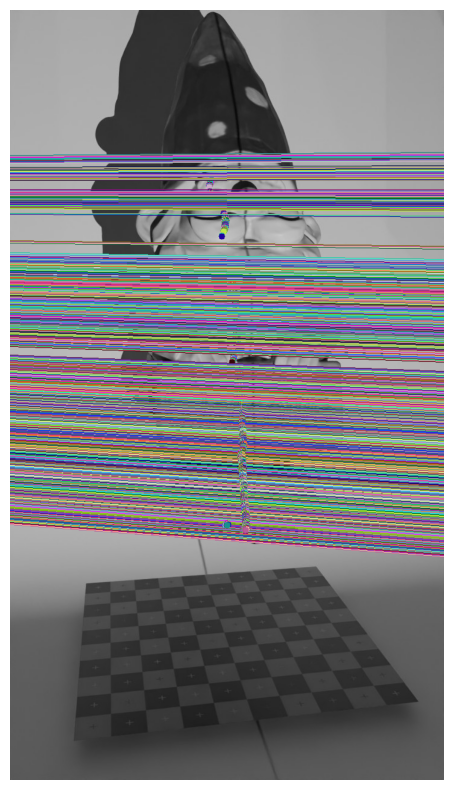

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

def compute_epilines(points, which_image, F):
    """计算对极线"""
    if points.shape[0] == 0:
        return None
    lines = cv2.computeCorrespondEpilines(points.reshape(-1, 1, 2), which_image, F)
    return lines.reshape(-1, 3) if lines is not None else None

def find_correspondences(left_pts, right_pts, F, threshold=5):
    """在对极线附近匹配特征点，并使用RANSAC进行进一步筛选"""
    if len(left_pts) == 0 or len(right_pts) == 0:
        return []

    left_pts = np.float32(left_pts)
    right_pts = np.float32(right_pts)

    lines_right = compute_epilines(left_pts, 1, F)
    if lines_right is None:
        print("Error computing epilines for right points.")
        return []

    potential_matches = []
    for i, line in enumerate(lines_right):
        pt1 = left_pts[i]
        distances = np.abs(line[0] * right_pts[:, 0] + line[1] * right_pts[:, 1] + line[2]) / np.sqrt(line[0]**2 + line[1]**2)
        min_dist_idx = np.argmin(distances)
        if distances[min_dist_idx] < threshold:  # 阈值调整
            pt2 = right_pts[min_dist_idx]
            potential_matches.append((pt1, pt2))

    # 使用RANSAC进行进一步筛选
    if len(potential_matches) < 2:
        return []

    src_pts = np.float32([m[0] for m in potential_matches])
    dst_pts = np.float32([m[1] for m in potential_matches])
    ransac = RANSACRegressor()
    ransac.fit(src_pts, dst_pts)
    inlier_mask = ransac.inlier_mask_

    matches = [(src_pts[i], dst_pts[i]) for i in range(len(inlier_mask)) if inlier_mask[i]]
    return matches

def visualize_correspondences_side_by_side(left_img, right_img, matches):
    # Create a combined image by concatenating left and right images side by side
    combined_img = np.concatenate((left_img, right_img), axis=1)

    # Plot the combined image
    plt.figure(figsize=(20, 10))
    plt.imshow(combined_img, cmap='gray')

    # Draw lines connecting the points in the left image to their correspondences in the right image
    for left_pt, right_pt in matches:
        plt.scatter(left_pt[0], left_pt[1], color='red', s=1)  # Smaller point size
        plt.scatter(right_pt[0] + left_img.shape[1], right_pt[1], color='blue', s=1)  # Smaller point size
        plt.plot([left_pt[0], right_pt[0] + left_img.shape[1]], [left_pt[1], right_pt[1]], color='yellow', linewidth=0.1)  # Thinner line

    plt.axis('off')
    plt.show()

def load_coordinates(file_path):
    coords = []
    with open(file_path, 'r') as file:
        for line in file:
            y, x = map(int, line.strip().split(','))  # Note the reversed order
            coords.append([x, y])  # Ensure coordinates are in x, y order
    return np.array(coords)

def draw_epilines_on_right_image(right_img, lines, left_pts):
    """在右图上绘制由左图计算得到的对极线"""
    img_color = cv2.cvtColor(right_img, cv2.COLOR_GRAY2BGR)
    r, c = right_img.shape

    for r, pt in zip(lines, left_pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img_color = cv2.line(img_color, (x0, y0), (x1, y1), color, 1)
        img_color = cv2.circle(img_color, tuple(pt), 5, color, -1)
    return img_color

# Example usage
file_name_index = "0085"
left_img_path = "output_images/original_L/original_" + file_name_index + ".jpg"
right_img_path = "output_images/original_R/original_" + file_name_index + ".jpg"
coords_L_path = "output_images/coords_L/coords_original_" + file_name_index + ".txt"
coords_R_path = "output_images/coords_R/coords_original_" + file_name_index + ".txt"

left_img = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

left_pts = load_coordinates(coords_L_path)
right_pts = load_coordinates(coords_R_path)

# Filter out points that are out of bounds for the left image
left_pts = np.array([pt for pt in left_pts if pt[0] < left_img.shape[1] and pt[1] < left_img.shape[0]])
right_pts = np.array([pt for pt in right_pts if pt[0] < right_img.shape[1] and pt[1] < right_img.shape[0]])

# Fundamental Matrix (example values, you should replace these with your actual fundamental matrix)
F = np.array([[3.283965767647195E-7, -6.76098398189792E-6, 0.0021123144539793737],
              [-8.046341661808292E-6, 3.05632173594769E-8, 0.05124913199417346],
              [0.0048160232373805345, -0.051062699158041805, 1.0706286680443888]])

# Compute epilines for left points and draw them on right image
lines_right = compute_epilines(left_pts, 1, F)
right_img_lines = draw_epilines_on_right_image(right_img, lines_right, left_pts)

matches = find_correspondences(left_pts, right_pts, F)
print("Matches: ", matches)

visualize_correspondences_side_by_side(left_img, right_img, matches)

# Display the right image with epilines
plt.figure(figsize=(10, 10))
plt.imshow(right_img_lines)
plt.axis('off')
plt.show()


不儲epipolor line照片  遍歷版把所有matchimg poits 存到TXT

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

def compute_epilines(points, which_image, F):
    """计算对极线"""
    if points.shape[0] == 0:
        return None
    lines = cv2.computeCorrespondEpilines(points.reshape(-1, 1, 2), which_image, F)
    return lines.reshape(-1, 3) if lines is not None else None

def find_correspondences(left_pts, right_pts, F, threshold=5):
    """在对极线附近匹配特征点，并使用RANSAC进行进一步筛选"""
    if len(left_pts) == 0 or len(right_pts) == 0:
        return []

    left_pts = np.float32(left_pts)
    right_pts = np.float32(right_pts)

    lines_right = compute_epilines(left_pts, 1, F)
    if lines_right is None:
        print("Error computing epilines for right points.")
        return []

    potential_matches = []
    for i, line in enumerate(lines_right):
        pt1 = left_pts[i]
        distances = np.abs(line[0] * right_pts[:, 0] + line[1] * right_pts[:, 1] + line[2]) / np.sqrt(line[0]**2 + line[1]**2)
        min_dist_idx = np.argmin(distances)
        if distances[min_dist_idx] < threshold:  # 阈值调整
            pt2 = right_pts[min_dist_idx]
            potential_matches.append((pt1, pt2))

    # 使用RANSAC进行进一步筛选
    if len(potential_matches) < 2:
        return []

    src_pts = np.float32([m[0] for m in potential_matches])
    dst_pts = np.float32([m[1] for m in potential_matches])
    ransac = RANSACRegressor()
    ransac.fit(src_pts, dst_pts)
    inlier_mask = ransac.inlier_mask_

    matches = [(src_pts[i], dst_pts[i]) for i in range(len(inlier_mask)) if inlier_mask[i]]
    return matches

def visualize_correspondences_side_by_side(left_img, right_img, matches, save_path):
    # Create a combined image by concatenating left and right images side by side
    combined_img = np.concatenate((left_img, right_img), axis=1)

    # Plot the combined image
    plt.figure(figsize=(20, 10))
    plt.imshow(combined_img, cmap='gray')

    # Draw lines connecting the points in the left image to their correspondences in the right image
    for left_pt, right_pt in matches:
        plt.scatter(left_pt[0], left_pt[1], color='red', s=1)  # Smaller point size
        plt.scatter(right_pt[0] + left_img.shape[1], right_pt[1], color='blue', s=1)  # Smaller point size
        plt.plot([left_pt[0], right_pt[0] + left_img.shape[1]], [left_pt[1], right_pt[1]], color='yellow', linewidth=0.1)  # Thinner line

    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def load_coordinates(file_path):
    coords = []
    with open(file_path, 'r') as file:
        for line in file:
            y, x = map(int, line.strip().split(','))  # Note the reversed order
            coords.append([x, y])  # Ensure coordinates are in x, y order
    return np.array(coords)

def draw_epilines_on_right_image(right_img, lines, left_pts):
    """在右图上绘制由左图计算得到的对极线"""
    img_color = cv2.cvtColor(right_img, cv2.COLOR_GRAY2BGR)
    r, c = right_img.shape

    for r, pt in zip(lines, left_pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img_color = cv2.line(img_color, (x0, y0), (x1, y1), color, 1)
        img_color = cv2.circle(img_color, tuple(pt), 5, color, -1)
    return img_color

def save_matches(matches, file_path):
    """保存匹配的坐标点对到TXT文件"""
    with open(file_path, 'w') as file:
        for pt1, pt2 in matches:
            file.write(f"{int(pt1[0])},{int(pt1[1])},{int(pt2[0])},{int(pt2[1])}\n")
    print(f"Saved matches to {file_path}")

# 指定路径
left_img_dir = 'output_images/original_L'
right_img_dir = 'output_images/original_R'
coords_L_dir = 'output_images/coords_L'
coords_R_dir = 'output_images/coords_R'
output_vis_dir = 'output_images/visualized_correspondences'
output_matches_dir = 'output_images/matches'

# 创建输出目录
os.makedirs(output_vis_dir, exist_ok=True)
os.makedirs(output_matches_dir, exist_ok=True)

# Fundamental Matrix (example values, you should replace these with your actual fundamental matrix)
F = np.array([[3.283965767647195E-7, -6.76098398189792E-6, 0.0021123144539793737],
              [-8.046341661808292E-6, 3.05632173594769E-8, 0.05124913199417346],
              [0.0048160232373805345, -0.051062699158041805, 1.0706286680443888]])

# 获取并排序文件名
left_files = sorted(os.listdir(left_img_dir))
right_files = sorted(os.listdir(right_img_dir))
coords_L_files = sorted(os.listdir(coords_L_dir))
coords_R_files = sorted(os.listdir(coords_R_dir))

# 确保文件名列表的长度一致
assert len(left_files) == len(right_files) == len(coords_L_files) == len(coords_R_files)

# 遍历所有输入文件
for index, (left_file, right_file, coords_L_file, coords_R_file) in enumerate(zip(left_files, right_files, coords_L_files, coords_R_files)):
    if left_file.endswith('.jpg') and right_file.endswith('.jpg') and coords_L_file.endswith('.txt') and coords_R_file.endswith('.txt'):
        left_img_path = os.path.join(left_img_dir, left_file)
        right_img_path = os.path.join(right_img_dir, right_file)
        coords_L_path = os.path.join(coords_L_dir, coords_L_file)
        coords_R_path = os.path.join(coords_R_dir, coords_R_file)
        output_vis_path = os.path.join(output_vis_dir, f'{index:04d}_visualization.jpg')
        output_matches_path = os.path.join(output_matches_dir, f'{index:04d}_matches.txt')

        # 读取图像和坐标
        left_img = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
        right_img = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)
        left_pts = load_coordinates(coords_L_path)
        right_pts = load_coordinates(coords_R_path)

        # 检查坐标点是否加载正确
        if len(left_pts) == 0:
            print(f"No points found in {coords_L_path}")
            continue
        if len(right_pts) == 0:
            print(f"No points found in {coords_R_path}")
            continue

        # 过滤图像边界外的点
        left_pts = np.array([pt for pt in left_pts if pt[0] < left_img.shape[1] and pt[1] < left_img.shape[0]])
        right_pts = np.array([pt for pt in right_pts if pt[0] < right_img.shape[1] and pt[1] < right_img.shape[0]])

        # 计算对极线并绘制在右图上
        lines_right = compute_epilines(left_pts, 1, F)
        right_img_lines = draw_epilines_on_right_image(right_img, lines_right, left_pts)

        # 找到匹配点
        matches = find_correspondences(left_pts, right_pts, F)
        print(f"Number of epipolar matches for {left_file}: {len(matches)}")

        # 保存匹配点对到TXT文件
        save_matches(matches, output_matches_path)

        # 可视化并保存匹配点
        # save epipolor line visualize matching points 
        # visualize_correspondences_side_by_side(left_img, right_img, matches, output_vis_path)


Number of epipolar matches for original_0000.jpg: 117
Saved matches to output_images/matches\0000_matches.txt
Number of epipolar matches for original_0001.jpg: 219
Saved matches to output_images/matches\0001_matches.txt
Number of epipolar matches for original_0002.jpg: 355
Saved matches to output_images/matches\0002_matches.txt
Number of epipolar matches for original_0003.jpg: 534
Saved matches to output_images/matches\0003_matches.txt
Number of epipolar matches for original_0004.jpg: 637
Saved matches to output_images/matches\0004_matches.txt
Number of epipolar matches for original_0005.jpg: 696
Saved matches to output_images/matches\0005_matches.txt
Number of epipolar matches for original_0006.jpg: 778
Saved matches to output_images/matches\0006_matches.txt
Number of epipolar matches for original_0007.jpg: 893
Saved matches to output_images/matches\0007_matches.txt
Number of epipolar matches for original_0008.jpg: 942
Saved matches to output_images/matches\0008_matches.txt
Number of 

3D

In [6]:
import os
import numpy as np
import cv2

def load_matches(file_path):
    """加载匹配点对"""
    matches = []
    with open(file_path, 'r') as file:
        for line in file:
            x1, y1, x2, y2 = map(int, line.strip().split(','))
            matches.append(((x1, y1), (x2, y2)))
    return matches

def reconstruct_3d_points(matches, K_left, RT_left, K_right, RT_right):
    """通过匹配点对和相机参数重建3D点"""
    P_left = K_left @ RT_left
    P_right = K_right @ RT_right

    pts1 = []
    pts2 = []

    for (pt1, pt2) in matches:
        pts1.append([pt1[0], pt1[1]])
        pts2.append([pt2[0], pt2[1]])

    pts1 = np.array(pts1, dtype=np.float32).T
    pts2 = np.array(pts2, dtype=np.float32).T

    # 检查pts1和pts2的形状
    print(f"Shape of pts1: {pts1.shape}")
    print(f"Shape of pts2: {pts2.shape}")

    points_4d_hom = cv2.triangulatePoints(P_left, P_right, pts1, pts2)
    points_3d = points_4d_hom[:3] / points_4d_hom[3]

    return points_3d.T

def save_3d_points(points_3d, file_path):
    """保存3D点到XYZ文件"""
    with open(file_path, 'w') as file:
        for pt in points_3d:
            file.write(f"{pt[0]:.6f} {pt[1]:.6f} {pt[2]:.6f}\n")
    print(f"Saved 3D points to {file_path}")


In [7]:
# 相机内参矩阵
K_left = np.array([[1000.0, 0.0, 360.0],
                   [0.0, 1000.0, 640.0],
                   [0.0, 0.0, 1.0]])

RT_left = np.array([[0.88649035, -0.46274707, -0.00, -14.42428],
                    [-0.070794605, -0.13562201, -0.98822814, 86.532959],
                    [0.45729965, 0.8760547, -0.1529876, 235.35446]])

K_right = np.array([[1100.0, 0.0, 360.0],
                    [0.0, 1100.0, 640.0],
                    [0.0, 0.0, 1.0]])

RT_right = np.array([[0.98480779, -0.17364818, -4.9342116E-8, -0.98420829],
                     [-0.026566068, -0.15066338, -0.98822814, 85.070221],
                     [0.17160401, 0.97321475, -0.1529876, 236.97873]])


In [8]:
# 指定路径
matches_dir = 'output_images/matches/'
output_3d_path = 'output_images/all_3d_points.xyz'

# 创建保存所有3D点的文件
with open(output_3d_path, 'w') as output_file:
    # 遍历匹配点对文件
    for file_name in os.listdir(matches_dir):
        if file_name.endswith('_matches.txt'):
            matches_file_path = os.path.join(matches_dir, file_name)

            # 加载匹配点对
            matches = load_matches(matches_file_path)

            # 打印匹配点对数目
            print(f"Processing {file_name}, Number of matches: {len(matches)}")

            # 通过匹配点对重建3D点
            if len(matches) > 0:
                points_3d = reconstruct_3d_points(matches, K_left, RT_left, K_right, RT_right)

                # 保存3D点到单一XYZ文件
                if points_3d.size > 0:
                    for pt in points_3d:
                        output_file.write(f"{pt[0]:.6f} {pt[1]:.6f} {pt[2]:.6f}\n")
                else:
                    print(f"Failed to reconstruct 3D points for {file_name}")
            else:
                print(f"No matches to reconstruct 3D points for {file_name}")

print(f"Saved all 3D points to {output_3d_path}")


Processing 0000_matches.txt, Number of matches: 117
Shape of pts1: (2, 117)
Shape of pts2: (2, 117)
Processing 0001_matches.txt, Number of matches: 219
Shape of pts1: (2, 219)
Shape of pts2: (2, 219)
Processing 0002_matches.txt, Number of matches: 355
Shape of pts1: (2, 355)
Shape of pts2: (2, 355)
Processing 0003_matches.txt, Number of matches: 534
Shape of pts1: (2, 534)
Shape of pts2: (2, 534)
Processing 0004_matches.txt, Number of matches: 637
Shape of pts1: (2, 637)
Shape of pts2: (2, 637)
Processing 0005_matches.txt, Number of matches: 696
Shape of pts1: (2, 696)
Shape of pts2: (2, 696)
Processing 0006_matches.txt, Number of matches: 778
Shape of pts1: (2, 778)
Shape of pts2: (2, 778)
Processing 0007_matches.txt, Number of matches: 893
Shape of pts1: (2, 893)
Shape of pts2: (2, 893)
Processing 0008_matches.txt, Number of matches: 942
Shape of pts1: (2, 942)
Shape of pts2: (2, 942)
Processing 0009_matches.txt, Number of matches: 1077
Shape of pts1: (2, 1077)
Shape of pts2: (2, 107